In [ ]:
#@title Import modules.
## Version utilisant le tutoriel à modifier


!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install imageio
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]

from IPython.display import clear_output
clear_output()

#@title Import modules.
#python3

import copy
import pyvirtualdisplay
import imageio 
import base64
import IPython
import numpy as np


from acme import environment_loop
from acme.tf import networks
from acme.adders import reverb as adders
from acme.agents.tf import actors as actors
from acme.datasets import reverb as datasets
from acme.wrappers import gym_wrapper
from acme import specs
from acme import wrappers
from acme.agents.tf import d4pg
from acme.agents import agent
from acme.tf import utils as tf2_utils
from acme.utils import loggers

import gym 
import dm_env
import matplotlib.pyplot as plt
import numpy as np
import reverb
import sonnet as snt
import tensorflow as tf

# Import dm_control if it exists.
try:
  from dm_control import suite
except (ModuleNotFoundError, OSError):
  pass

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

/usr/local/lib/python3.6/dist-packages/glfw/__init__.py:834: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


(-0.5, 599.5, 399.5, -0.5)

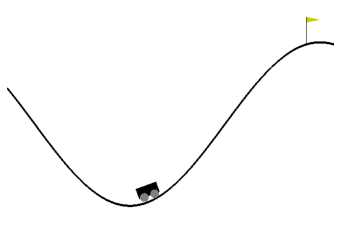

In [ ]:
environment_name = 'gym_mountaincar'  # @param ['dm_cartpole', 'gym_mountaincar']
# task_name = 'balance'  # @param ['swingup', 'balance']

def make_environment(domain_name='cartpole', task='balance'):
  env = suite.load(domain_name, task)
  env = wrappers.SinglePrecisionWrapper(env)
  return env

if 'dm_cartpole' in environment_name:
  environment = make_environment('cartpole')
  def render(env):
    return env._physics.render(camera_id=0)  #pylint: disable=protected-access

elif 'gym_mountaincar' in environment_name:
  environment = gym_wrapper.GymWrapper(gym.make('MountainCarContinuous-v0'))
  environment = wrappers.SinglePrecisionWrapper(environment)
  def render(env):
    return env.environment.render(mode='rgb_array')
else:
  raise ValueError('Unknown environment: {}.'.format(environment_name))

# Show the frame.
frame = render(environment)
plt.imshow(frame)
plt.axis('off')

# Environment spec

In [ ]:
environment_spec = specs.make_environment_spec(environment)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 BoundedArray(shape=(1,), dtype=dtype('float32'), name='action', minimum=[-1.], maximum=[1.]) 

observations:
 BoundedArray(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07]) 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 



# Build the policy

In [ ]:
# Calculate how big the last layer should be based on total # of actions.
action_spec = environment_spec.actions
action_size = np.prod(action_spec.shape, dtype=int)
exploration_sigma = 0.3

# In order the following modules:
# 1. Flatten the observations to be [B, ...] where B is the batch dimension.
# 2. Define a simple MLP which is the guts of this policy.
# 3. Make sure the output action matches the spec of the actions.
policy_modules = [
    tf2_utils.batch_concat,
    networks.LayerNormMLP(layer_sizes=(300, 200, action_size)),
    networks.TanhToSpec(spec=environment_spec.actions)]

policy_network = snt.Sequential(policy_modules)

# We will also create a version of this policy that uses exploratory noise.
behavior_network = snt.Sequential(
    policy_modules + [networks.ClippedGaussian(exploration_sigma),
                      networks.ClipToSpec(action_spec)])

# Create the actor

In [ ]:
actor = actors.FeedForwardActor(policy_network)
[method_or_attr for method_or_attr in dir(actor)  # pylint: disable=expression-not-assigned
 if not method_or_attr.startswith('_')]

['observe', 'observe_first', 'select_action', 'update']

# Evaluate the random actor's policy

In [ ]:
def display_video(frames, filename='temp.mp4'):
  """Save and display video."""
  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      video.append_data(frame)
  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)


# Run the actor in the environment for desired number of steps.
frames = []
num_steps = 500
timestep = environment.reset()

for _ in range(num_steps):
  frames.append(render(environment))
  action = actor.select_action(timestep.observation)
  timestep = environment.step(action)

# Save video of the behaviour.
display_video(np.array(frames))

# Storing actor experiences in a replay buffer

In [ ]:
# Create a table with the following attributes:
# 1. when replay is full we remove the oldest entries first.
# 2. to sample from replay we will do so uniformly at random.
# 3. before allowing sampling to proceed we make sure there is at least
#    one sample in the replay table.
# 4. we use a default table name so we don't have to repeat it many times below;
#    if we left this off we'd need to feed it into adders/actors/etc. below.
replay_buffer = reverb.Table(
    name=adders.DEFAULT_PRIORITY_TABLE,
    max_size=1000000,
    remover=reverb.selectors.Fifo(),
    sampler=reverb.selectors.Uniform(),
    rate_limiter=reverb.rate_limiters.MinSize(min_size_to_sample=1))

# Get the server and address so we can give it to the modules such as our actor
# that will interact with the replay buffer.
replay_server = reverb.Server([replay_buffer], port=None)
replay_server_address = 'localhost:%d' % replay_server.port


# Create a 5-step transition adder where in between those steps a discount of
# 0.99 is used (which should be the same discount used for learning).
adder = adders.NStepTransitionAdder(
    client=reverb.Client(replay_server_address),
    n_step=5,
    discount=0.99)

num_episodes = 2  #@param

for episode in range(num_episodes):
  timestep = environment.reset()
  adder.add_first(timestep)

  while not timestep.last():
    action = actor.select_action(timestep.observation)
    timestep = environment.step(action)
    adder.add(action=action, next_timestep=timestep)

actor = actors.FeedForwardActor(policy_network=behavior_network, adder=adder)
num_episodes = 2  #@param

for episode in range(num_episodes):
  timestep = environment.reset()
  actor.observe_first(timestep)  # Note: observe_first.

  while not timestep.last():
    action = actor.select_action(timestep.observation)
    timestep = environment.step(action)
    actor.observe(action=action, next_timestep=timestep)  # Note: observe

# Learning from experience

In [ ]:
# This connects to the created reverb server; also note that we use a transition
# adder above so we'll tell the dataset function that so that it knows the type
# of data that's coming out.
dataset = datasets.make_dataset(
    server_address=replay_server_address,
    batch_size=256,
    environment_spec=environment_spec,
    transition_adder=True)

critic_network = snt.Sequential([
    networks.CriticMultiplexer(
        observation_network=tf2_utils.batch_concat,
        action_network=tf.identity,
        critic_network=networks.LayerNormMLP(
            layer_sizes=(400, 300),
            activate_final=True)),
    # Value-head gives a 51-atomed delta distribution over state-action values.
    networks.DiscreteValuedHead(vmin=-150., vmax=150., num_atoms=51)])

# Create the target networks
target_policy_network = copy.deepcopy(policy_network)
target_critic_network = copy.deepcopy(critic_network)

# We must create the variables in the networks before passing them to learner.
tf2_utils.create_variables(network=policy_network,
                           input_spec=[environment_spec.observations])
tf2_utils.create_variables(network=critic_network,
                           input_spec=[environment_spec.observations,
                                       environment_spec.actions])
tf2_utils.create_variables(network=target_policy_network,
                           input_spec=[environment_spec.observations])
tf2_utils.create_variables(network=target_critic_network,
                           input_spec=[environment_spec.observations,
                                       environment_spec.actions])

learner = d4pg.D4PGLearner(policy_network=policy_network,
                           critic_network=critic_network,
                           target_policy_network=target_policy_network,
                           target_critic_network=target_critic_network,
                           dataset=dataset,
                           discount=0.99,
                           target_update_period=100,
                           policy_optimizer=snt.optimizers.Adam(1e-4),
                           critic_optimizer=snt.optimizers.Adam(1e-4),
                           # Log learner updates to console every 10 seconds.
                           logger=loggers.TerminalLogger(time_delta=10.),
                           checkpoint=False)

[method_or_attr for method_or_attr in dir(learner)  # pylint: disable=expression-not-assigned
 if not method_or_attr.startswith('_')]
learner.step()


# Training loop

In [ ]:
adder.reset()

num_training_episodes =  10 # @param {type: "integer"}
min_actor_steps_before_learning = 1000  # @param {type: "integer"}
num_actor_steps_per_iteration =   100 # @param {type: "integer"}
num_learner_steps_per_iteration = 1  # @param {type: "integer"}

learner_steps_taken = 0
actor_steps_taken = 0
episode_reward=[]
episode_liste=[]


for episode in range(num_training_episodes):
  
  timestep = environment.reset()
  actor.observe_first(timestep)
  episode_return = 0


  while not timestep.last():
    # Get an action from the agent and step in the environment.
    action = actor.select_action(timestep.observation)
    next_timestep = environment.step(action)

    # Record the transition.
    actor.observe(action=action, next_timestep=next_timestep)

    # Book-keeping.
    episode_return += next_timestep.reward
    actor_steps_taken += 1
    timestep = next_timestep


    # See if we have some learning to do.
    if (actor_steps_taken >= min_actor_steps_before_learning and
        actor_steps_taken % num_actor_steps_per_iteration == 0):
      # Learn.
      for learner_step in range(num_learner_steps_per_iteration):
        learner.step()
      learner_steps_taken += num_learner_steps_per_iteration    


  # Log quantities.
  print('Episode: %d | Return: %f | Learner steps: %d | Actor steps: %d'%(
      episode, episode_return, learner_steps_taken, actor_steps_taken))
  episode_liste.append(episode)
  episode_reward.append(episode_return)
  print(episode_reward)

  #episode_reward.append(episode_return)

Episode: 0 | Return: -78.956246 | Learner steps: 0 | Actor steps: 999
[-78.95624576869886]
Critic Loss = 3.887 | Policy Loss = 0.500 | Steps = 3 | Walltime = 5.421
Episode: 1 | Return: -79.885599 | Learner steps: 10 | Actor steps: 1998
[-78.95624576869886, -79.8855992279423]
Episode: 2 | Return: -80.939259 | Learner steps: 20 | Actor steps: 2997
[-78.95624576869886, -79.8855992279423, -80.9392587520415]
Episode: 3 | Return: -81.391372 | Learner steps: 30 | Actor steps: 3996
[-78.95624576869886, -79.8855992279423, -80.9392587520415, -81.39137192667113]
Episode: 4 | Return: -79.878615 | Learner steps: 40 | Actor steps: 4995
[-78.95624576869886, -79.8855992279423, -80.9392587520415, -81.39137192667113, -79.87861502791202]
Episode: 5 | Return: -80.066463 | Learner steps: 50 | Actor steps: 5994
[-78.95624576869886, -79.8855992279423, -80.9392587520415, -81.39137192667113, -79.87861502791202, -80.06646326562623]
Episode: 6 | Return: -79.369256 | Learner steps: 60 | Actor steps: 6993
[-78.956

Introduce ACME Agent

In [ ]:
d4pg_agent = agent.Agent(actor=actor,
                         learner=learner,
                         min_observations=1000,
                         observations_per_step=8.)

In [ ]:
#First test : white/gaussian noise
def white_noise(mu, sigma, current_env_spec):
  dim = np.size(current_env_spec.observations)
  noise = np.random.normal(mu, sigma, dim) #generate noise through random signal
  return (noise)

'''e=0,95'''
print(d4pg_agent.select_action)
def actionDecorator(og_function):
  def nestedFunction(*args, **kwargs):
    print(*args)
    print(**kwargs)
    E = white_noise(0,1,environment_spec)
    args[0][0]=args[0][0]+E
    args[0][1]=args[0][1]+E
    #print(args[0][1])
    results = og_function(*args, **kwargs)
    return results
  return nestedFunction

d4pg_agent.select_action = actionDecorator(d4pg_agent.select_action)
print(d4pg_agent.select_action)

<bound method Agent.select_action of <acme.agents.agent.Agent object at 0x7fc794a3ab38>>
<function actionDecorator.<locals>.nestedFunction at 0x7fc77b4bd8c8>


Training the full loop

In [ ]:
#This may be necessary if any of the episodes were cancelled above.
adder.reset()

# We also want to make sure the logger doesn't write to disk because that can
# cause issues in colab on occasion.
logger = loggers.TerminalLogger(time_delta=10.)

loop = environment_loop.EnvironmentLoop(environment, d4pg_agent,logger=logger)
loop.run(num_episodes=200)



[-0.4826802  0.       ]

[-0.4844863  -0.00180612]

[-0.487771   -0.00328469]

[-0.49203676 -0.00426576]

[-0.49699545 -0.00495868]

[-0.50365347 -0.006658  ]

[-0.5119609 -0.0083075]

[-0.5218557  -0.00989476]

[-0.5315789  -0.00972317]

[-0.5403532  -0.00877431]

[-0.5505019 -0.0101487]

[-0.561949   -0.01144715]

[-0.5716092  -0.00966016]

[-0.5824105  -0.01080132]

[-0.59427303 -0.01186252]

[-0.6071094  -0.01283642]

[-0.6204609  -0.01335146]

[-0.6343559 -0.013895 ]

[-0.6478716  -0.01351571]

[-0.66187334 -0.01400171]

[-0.676114   -0.01424067]

[-0.6907503 -0.0146363]

[-0.7026848  -0.01193454]

[-0.71483994 -0.01215509]

[-0.7271381  -0.01229818]

[-0.73896277 -0.01182469]

[-0.7505791  -0.01161633]

[-0.7595864  -0.00900727]

[-0.76846796 -0.00888155]

[-0.7768873  -0.00841937]

[-0.7850846  -0.00819731]

[-0.79301584 -0.00793121]

[-0.80063933 -0.00762351]

[-0.8078814  -0.00724208]

[-0.8147406  -0.00685918]

[-0.818748   -0.00400741]

[-0.82156134 -0.00281331]

[-0.8239258

KeyboardInterrupt: ignored

# Evaluate D4PG

In [ ]:
# Run the actor in the environment for desired number of steps.
frames = []
num_steps = 1000
timestep = environment.reset()

for _ in range(num_steps):
  frames.append(render(environment))
  action = d4pg_agent.select_action(timestep.observation)
  timestep = environment.step(action)

# Save video of the behaviour.
display_video(np.array(frames))

# Graph

In [ ]:
import numpy as np
from statistics import NormalDist

#test de normalité de Shapiro-Francia (renvoie ro(X,Z))
def test_norm_SF(X):
    n=X.shape[0]
    muX=sum(X)/n
    sigX=(sum(X**2)/n)-muX**2
    X=sorted(X)
    Fc=np.zeros(n)
    for i in range(1,n+1):
        Fc[i-1]=(i-0.375)/(n+0.25)
    Z=np.zeros(n)
    for i in range(n):
        Z[i]=NormalDist().inv_cdf(Fc[i])
    muZ=sum(Z)/n
    sigZ=sum(Z**2)/n-muZ**2
    c=0
    for i in range(n):
        c+=X[i]*Z[i]
    return (c/n-muX*muZ)/np.sqrt(sigX*sigZ)

#test d'indépendance (entrée : n(i,j), renvoie KH)
def test_indep(N):
    n=sum(sum(N))
    l,m=N.shape
    freq_marg_ligne=np.zeros(l)
    freq_marg_col=np.zeros(m)
    for i in range(l):
        freq_marg_ligne[i]=sum(N[i,:])
    for i in range(m):
        freq_marg_col[i]=sum(N[:,i])
    pp=np.zeros((l,m))
    for i in range(l):
        for j in range(m):
            pp[i][j]=freq_marg_ligne[i]*freq_marg_col[j]
    KH=0
    for i in range(l):
        for j in range(m):
            KH+=((N[i][j]-pp[i][j]/n)**2)/(pp[i][j]/n)
    return KH

#test d'adéquation à un loi (renvoie KH)
def test_adeq(N,P):
    n=sum(N)
    KH=0
    A=n*P
    for i in range(N.shape[0]):
        KH+=((N[i]-A[i])**2)/A[i]
    return KH

#test d'homogénéité  (renvoie KH)
#--->utiliser test_indep

ImportError: ignored